# Tutorial: `batch`

`hs_process.batch` extends the functionality of the core modules of `hs_process` ([segment](api/hs_process.segment.html#hs_process.segment), [spatial_mod](api/hs_process.spatial_mod.html#hs_process.spatial_mod), and [spec_mod](api/hs_process.spec_mod.html#hs_process.spec_mod)) so that image processing can run via a *relatively straightforward* script without end user interaction.

The overall goal of the `batch` module is to implement many post-processing steps across many datacubes via an easy-to-use API. It was designed to save all data products (intermediate or final) to disk. Any unwanted files must be manually deleted by the user.

***

## Sample data
Sample imagery captured from a [Resonon](https://resonon.com/) Pika II VIS-NIR line scanning imager and ancillary sample files can be downloaded from this [link](https://drive.google.com/drive/folders/1KpOBB4-qghedVFd8ukQngXNwUit8PFy_?usp=sharing).

Before trying this tutorial on your own machine, please download the [sample files](https://drive.google.com/drive/folders/1KpOBB4-qghedVFd8ukQngXNwUit8PFy_?usp=sharing) and place into a local directory of your choosing (and do not change the file names). Indicate the location of your sample files by modifying `data_dir`:

In [1]:
data_dir = r'F:\\nigo0024\Documents\hs_process_demo'

***

## Confirm your environment

Before trying the tutorials, be sure `hs_process` and its dependencies are [properly installed](installation.html#). If you installed in a *virtual environment*, first check we are indeed using the Python instance that was installed with the virtual environment:

In [2]:
import sys
print('Python install location: {0}'.format(sys.executable))

Python install location: C:\Users\nigo0024\Anaconda3\envs\msi_sip\python.exe


The *spec* folder that contains `python.exe` tells me that the activated Python instance is indeed in the `spec` environment, just as I intend. If you created a virtual environment, but your `python.exe` is not in the `envs\spec` directory, you either did not properly create your virtual environment or you are not pointing to the correct Python installation in your IDE (e.g., Spyder, Jupyter notebook, etc.).

***

## `batch.cube_to_spectra`
Calculates the mean and standard deviation for each cube in `fname_list` and writes the result to a ".spec" file. [[API]](api/hs_process.batch.html#hs_process.batch.cube_to_spectra)

**Note:** The following `batch` example builds on the results of the [`spatial_mod.crop_many_gdf` tutorial](tutorial_spatial_mod.html#spatial_mod.crop_many_gdf). Please complete the [`spatial_mod.crop_many_gdf`](tutorial_spatial_mod.html#spatial_mod.crop_many_gdf) example to be sure your directory (i.e., `base_dir`) is populated with multiple hyperspectral datacubes. The following example will be using datacubes located in the following directory: `F:\\nigo0024\Documents\hs_process_demo\spatial_mod\crop_many_gdf`

Load and initialize the `batch` module, checking to be sure the directory exists.

In [3]:
import os
from hs_process import batch

base_dir = os.path.join(data_dir, 'spatial_mod', 'crop_many_gdf')
print(os.path.isdir(base_dir))
hsbatch = batch(base_dir, search_ext='.bip',
                progress_bar=True)  # searches for all files in ``base_dir`` with a ".bip" file extension

True


Use `batch.cube_to_spectra` to calculate the *mean* and *standard deviation* across all pixels for each of the datacubes in `base_dir`.

In [4]:
hsbatch.cube_to_spectra(base_dir=base_dir, write_geotiff=False, out_force=True)

cube_to_spectra: |----------------------------------------------------------------------------------------------------| 0.0% 

Processing file 39/40: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 16.13it/s]


Use [`seaborn`](https://seaborn.pydata.org/index.html) to visualize the spectra of plots 1011, 1012, and 1013. Notice how ``hsbatch.io.name_plot`` is utilized to retrieve the plot ID, and how the *"history"* tag is referenced from the metadata to determine the number of pixels whose reflectance was averaged to create the mean spectra. Also remember that pixels across the original input image likely represent a combination of soil, vegetation, and shadow.

Text(0.5, 1.0, 'API Example: `batch.cube_to_spectra`')

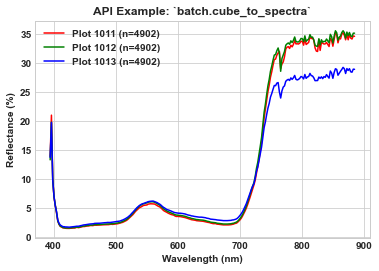

In [5]:
import seaborn as sns
import re

fname_list = [os.path.join(data_dir, 'spatial_mod', 'crop_many_gdf', 'cube_to_spec', 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1011-cube-to-spec-mean.spec'),
              os.path.join(data_dir, 'spatial_mod', 'crop_many_gdf', 'cube_to_spec', 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1012-cube-to-spec-mean.spec'),
              os.path.join(data_dir, 'spatial_mod', 'crop_many_gdf', 'cube_to_spec', 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1013-cube-to-spec-mean.spec')]

colors = ['red', 'green', 'blue']

for fname, color in zip(fname_list, colors):
    hsbatch.io.read_spec(fname)
    meta_bands = list(hsbatch.io.tools.meta_bands.values())
    data = hsbatch.io.spyfile_spec.load().flatten() * 100
    hist = hsbatch.io.spyfile_spec.metadata['history']
    pix_n = re.search('<pixel number: (.*)>', hist).group(1)
    ax = sns.lineplot(x=meta_bands, y=data, color=color, label='Plot '+hsbatch.io.name_plot+' (n='+pix_n+')')

ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `batch.cube_to_spectra`', weight='bold')

***

## `batch.segment_band_math`
Batch processing tool to perform band math on multiple datacubes in the same way. `batch.segment_band_math` is typically used prior to `batch.segment_create_mask` to generate the images/directory required for the masking process. [[API]](api/hs_process.batch.html#hs_process.batch.segment_band_math)

**Note:** The following `batch` example builds on the results of the [`spatial_mod.crop_many_gdf` tutorial](tutorial_spatial_mod.html#spatial_mod.crop_many_gdf). Please complete the [`spatial_mod.crop_many_gdf`](tutorial_spatial_mod.html#spatial_mod.crop_many_gdf) example to be sure your directory (i.e., `base_dir`) is populated with multiple hyperspectral datacubes. The following example will be using datacubes located in the following directory: `F:\\nigo0024\Documents\hs_process_demo\spatial_mod\crop_many_gdf`

Load and initialize the `batch` module, checking to be sure the directory exists.

In [6]:
import os
from hs_process import batch

base_dir = os.path.join(data_dir, 'spatial_mod', 'crop_many_gdf')
print(os.path.isdir(base_dir))
hsbatch = batch(base_dir, search_ext='.bip',
                progress_bar=True)  # searches for all files in ``base_dir`` with a ".bip" file extension

True


Use `batch.segment_band_math` to compute the MCARI2 (Modified Chlorophyll Absorption Ratio Index Improved; Haboudane et al., 2004) spectral index for each of the datacubes in ``base_dir``. See `Harris Geospatial`_ for more information about the MCARI2 spectral index and references to other spectral indices.

Processing file 39/40: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:13<00:00,  2.89it/s]


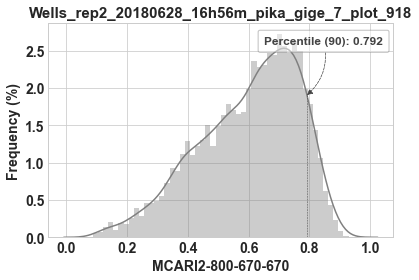

In [7]:
folder_name = 'band_math_mcari2-800-670-550'  # folder name can be modified to be more descriptive in what type of band math is being performed
method = 'mcari2'  # must be one of "ndi", "ratio", "derivative", or "mcari2"
wl1 = 800
wl2 = 670
wl3 = 550
hsbatch.segment_band_math(base_dir=base_dir, folder_name=folder_name,
                          name_append='band-math', write_geotiff=True,
                          method=method, wl1=wl1, wl2=wl2, wl3=wl3,
                          plot_out=True, out_force=True)

`batch.segment_band_math` creates a new folder in `base_dir` (in this case the new directory is `F:\\nigo0024\Documents\hs_process_demo\spatial_mod\crop_many_gdf\band_math_mcari2-800-670-550`), which contains several data products.

The **first** is `band-math-stats.csv`: a spreadsheet containing summary statistics for each of the image cubes that were processed via `batch.segment_band_math`; stats include *pixel count*, *mean*, *standard deviation*, *median*, and *percentiles* across all image pixels.

In [8]:
import pandas as pd

pd.read_csv(os.path.join(data_dir, 'spatial_mod', 'crop_many_gdf',
                         'band_math_mcari2-800-670-550', 'band-math-stats.csv')).head(5)

,fname,plot_id,count,mean,std_dev,median,pctl_10th,pctl_25th,pctl_50th,pctl_75th,pctl_90th,pctl_95th
0,F:\\nigo0024\Documents\hs_process_demo\spatial...,1011,3391,0.622999,0.154441,0.647932,0.400957,0.526855,0.647932,0.743904,0.802663,0.825942
1,F:\\nigo0024\Documents\hs_process_demo\spatial...,1012,4902,0.627408,0.137226,0.651605,0.432411,0.545338,0.651605,0.732981,0.783473,0.806512
2,F:\\nigo0024\Documents\hs_process_demo\spatial...,1013,4902,0.483455,0.170385,0.491520,0.244630,0.349948,0.491520,0.626670,0.698892,0.737506
3,F:\\nigo0024\Documents\hs_process_demo\spatial...,1014,4902,0.582990,0.175643,0.618471,0.315483,0.473933,0.618471,0.727224,0.779835,0.804277
4,F:\\nigo0024\Documents\hs_process_demo\spatial...,1015,4902,0.582303,0.161018,0.597912,0.351104,0.461747,0.597912,0.716367,0.782069,0.809144


**Second** is a `geotiff` file for each of the image cubes after the band math processing. This can be opened in *QGIS* to visualize in a spatial reference system, or can be opened using any software that supports floating point *.tif* files.

![band-math-mcari2-tif](../../docs/source/img/batch/segment_band_math_plot_611-band-math-mcari2-800-670-550_tif.png)

**Third** is the band math raster saved in the *.hdr* file format. Note that the data conained here should be the same as in the *.tif* file, so it's a matter of preference as to what may be more useful. This single band *.hdr* can also be opend in *QGIS*.

**Fourth** is a histogram of the band math data contained in the image. The histogram illustrates the 90th percentile value, which may be useful in the segmentation step (e.g., see [`batch.segment_create_mask`](tutorial_batch.html#batch.segment_create_mask)).

***

## `batch.segment_create_mask`
Batch processing tool to create a masked array on many datacubes. `batch.segment_create_mask` is typically used after `batch.segment_band_math` to mask all the datacubes in a directory based on the result of the band math process. [[API]](api/hs_process.batch.html#hs_process.batch.segment_create_mask)

**Note:** The following `batch` example builds on the results of the [`spatial_mod.crop_many_gdf` tutorial](tutorial_spatial_mod.html#spatial_mod.crop_many_gdf) and and [`batch.segment_band_math`](tutorial_batch.html#batch.segment_band_math). Please complete both the `spatial_mod.crop_many_gdf` and `batch.segment_band_math` tutorial examples to be sure your directories (i.e., `base_dir`, and `mask_dir`) are populated with image files. The following example will be using datacubes located in: `F:\\nigo0024\Documents\hs_process_demo\spatial_mod\crop_many_gdf`
based on MCARI2 images located in: `F:\\nigo0024\Documents\hs_process_demo\spatial_mod\crop_many_gdf\band_math_mcari2-800-670-550`

Load and initialize the `batch` module, ensuring `base_dir` is a valid directory

In [9]:
import os
from hs_process import batch

base_dir = os.path.join(data_dir, 'spatial_mod', 'crop_many_gdf')
print(os.path.isdir(base_dir))
hsbatch = batch(base_dir, search_ext='.bip',
                progress_bar=True)  # searches for all files in ``base_dir`` with a ".bip" file extension

True


There must be a single-band image that will be used to determine which datacube pixels are to be masked (determined via the `mask_dir` parameter). Point to the directory that contains the MCARI2 images.

In [10]:
mask_dir = os.path.join(base_dir, 'band_math_mcari2-800-670-550')
print(os.path.isdir(mask_dir))

True


Indicate how the MCARI2 images should be used to determine which hyperspectal pixels are to be masked. The available parameters for controlling this are `mask_thresh`, `mask_percentile`, and `mask_side`. We will mask out all pixels that fall below the MCARI2 90th percentile.

In [11]:
mask_percentile = 90
mask_side = 'lower'

Finally, indicate the folder to save the masked datacubes and perform the batch masking via `batch.segment_create_mask`

In [12]:
folder_name = 'mask_mcari2_90th'
hsbatch.segment_create_mask(base_dir=base_dir, mask_dir=mask_dir,
                            folder_name=folder_name,
                            name_append='mask-mcari2-90th', write_geotiff=True,
                            mask_percentile=mask_percentile,
                            mask_side=mask_side, out_force=True)

Processing file 0/40:   0%|                                                                              | 0/40 [00:00<?, ?it/s]C:\Users\nigo0024\Anaconda3\envs\msi_sip\lib\site-packages\spectral\io\spyfile.py:218: NaNValueWarning: Image data contains NaN values.
  warnings.warn('Image data contains NaN values.', NaNValueWarning)
Processing file 39/40: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.13it/s]


`batch.segment_create_mask` creates a new folder in `base_dir` named according to the `folder_name` parameter (in this case the new directory is `F:\\nigo0024\Documents\hs_process_demo\spatial_mod\crop_many_gdf\mask_mcari2_90th`) which contains several data products.

The **first** is `mask-stats.csv`: a spreadsheet containing the band math threshold value for each image file. In this example, the MCARI2 value corresponding to the 90th percentile is listed.

In [13]:
pd.read_csv(os.path.join(base_dir, 'mask_mcari2_90th', 'mask-stats.csv')).head(5)

,fname,plot_id,lower-pctl-90
0,F:\\nigo0024\Documents\hs_process_demo\spatial...,1011,0.832222
1,F:\\nigo0024\Documents\hs_process_demo\spatial...,1012,0.811119
2,F:\\nigo0024\Documents\hs_process_demo\spatial...,1013,0.743942
3,F:\\nigo0024\Documents\hs_process_demo\spatial...,1014,0.809496
4,F:\\nigo0024\Documents\hs_process_demo\spatial...,1015,0.813714


**Second** is a `geotiff` file for each of the image cubes after the masking procedure. This can be opened in *QGIS* to visualize in a spatial reference system, or can be opened using any software that supports floating point *.tif* files. The masked pixels are saved as `null` values and should render transparently.


![segment-create-mask-geotiff](../.././docs/source/img/batch/segment_create_mask_geotiff.png)

**Third** is the full hyperspectral datacube, also with the masked pixels saved as ``null`` values. Note that the only pixels remaining are the 10% with the highest MCARI2 values.

![segment-create-mask-datacube](../.././docs/source/img/batch/segment_create_mask_datacube.png)

**Fourth** is the mean spectra across the unmasked datacube pixels. This is illustrated above by the green line plot (the light green shadow represents the standard deviation for each band).

***

## `batch.spatial_crop`
Iterates through a spreadsheet that provides necessary information about how each image should be cropped and how it should be saved. [[API]](api/hs_process.batch.html#hs_process.batch.spatial_crop)

If `gdf` is passed (a `geopandas.GoeDataFrame` polygon file), the cropped images will be shifted to the center of appropriate "plot" polygon.

**Tips and Tricks for** `fname_sheet` **when** `gdf` **is not passed**

If `gdf` is not passed, `fname_sheet` may have the following required column headings that correspond to the relevant parameters in [`spatial_mod.crop_single`](tutorial_spatial_mod.html#spatial_mod.crop_single) and [`spatial_mod.crop_many_gdf`](tutorial_spatial_mod.html#spatial_mod.crop_many_gdf):

1. "directory"
2. "name_short"
3. "name_long"
4. "ext"
5. "pix_e_ul"
6. "pix_n_ul".

With this minimum input, `batch.spatial_crop` will read in each image, crop from the upper left pixel (determined as `pix_e_ul`/`pix_n_ul`) to the lower right pixel calculated based on `crop_e_pix`/`crop_n_pix` (which is the width of the cropped area in units of pixels).

**Note:** `crop_e_pix` and `crop_n_pix` have default values (see [`defaults.crop_defaults`](api/hs_process.defaults.html#hs_process.defaults)), but they can also be passed specifically for each datacube by including appropriate columns in `fname_sheet` (which takes precedence over `defaults.crop_defaults`).

`fname_sheet` may also have the following optional column headings:

1. "crop_e_pix"
2. "crop_n_pix"
3. "crop_e_m"
4. "crop_n_m"
5. "buf_e_pix"
6. "buf_n_pix"
7. "buf_e_m"
8. "buf_n_m"
9. "plot_id"

**More** ``fname_sheet`` **Tips and Tricks**

1. These optional inputs passed via `fname_sheet` allow more control  over exactly how the images are to be cropped. For a more detailed explanation of the information that many of these columns are intended to contain, see the documentation for [`spatial_mod.crop_single`](tutorial_spatial_mod.html#spatial_mod.crop_single) and [`spatial_mod.crop_many_gdf`](tutorial_spatial_mod.html#spatial_mod.crop_many_gdf). Those parameters not referenced should be apparent in the API examples and tutorials.
2. If the column names are different in `fname_sheet` than described here, [`defaults.spat_crop_cols`](api/hs_process.defaults.html#hs_process.defaults) can be modified to indicate which columns correspond to the relevant information.
3. Any other columns can be added to `fname_sheet`, but `batch.spatial_crop` does not use them in any way.

**Note:** The following `batch` example only actually processes *a single* hyperspectral image. If more datacubes were present in `base_dir`, however, `batch.spatial_crop` would process all datacubes that were available.

**Note:** This example uses `spatial_mod.crop_many_gdf` to crop many plots from a datacube using a polygon geometry file describing the spatial extent of each plot.
            
Load and initialize the `batch` module, checking to be sure the directory exists.

In [14]:
import os
import geopandas as gpd
import pandas as pd
from hs_process import batch

base_dir = data_dir
print(os.path.isdir(base_dir))
hsbatch = batch(base_dir, search_ext='.bip', dir_level=0,
                progress_bar=True)  # searches for all files in ``base_dir`` with a ".bip" file extension

True


Load the plot geometry as a `geopandas.GeoDataFrame`

In [15]:
fname_gdf = os.path.join(data_dir, 'plot_bounds.geojson')
gdf = gpd.read_file(fname_gdf)

Perform the spatial cropping using the *"many_gdf"* `method`. Note that nothing is being passed to `fname_sheet` here, so `batch.spatial_crop` is simply going to attempt to crop all plots contained within `gdf` that overlap with any datacubes in `base_dir`.

Passing `fname_sheet` directly is definitely more flexible for customization. However, some customization is possible while not passing `fname_sheet`. In the example below, we set an easting and northing buffer, as well as limit the number of plots to crop to 40. These defaults trickle through to `spatial_mod.crop_many_gdf()`, so by setting them on the `batch` object, they will be recognized when calculating crop boundaries from `gdf`.

In [16]:
hsbatch.io.defaults.crop_defaults.buf_e_m = 2  # Sets buffer in the easting direction (units of meters)
hsbatch.io.defaults.crop_defaults.buf_n_m = 0.5
hsbatch.io.defaults.crop_defaults.n_plots = 40  # We can limit the number of plots to process from gdf
hsbatch.spatial_crop(base_dir=base_dir, method='many_gdf',
                     gdf=gdf, out_force=True)

Because ``fname_list`` was passed instead of ``fname_sheet``, there is not a way to infer the study name and date. Therefore, "study" and "date" will be omitted from the output file name. If you would like output file names to include "study" and "date", please pass ``fname_sheet`` with "study" and "date" columns.



Processing file 39/40: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.54it/s]


A new folder was created in `base_dir` - `F:\\nigo0024\Documents\hs_process_demo\spatial_crop` - that contains the cropped datacubes and the cropped `geotiff` images. The Plot ID from the `gdf` is used to name each datacube according to its plot ID. The `geotiff` images can be opened in *QGIS* to visualize the images after cropping them.

![spatial-crop-tifs](../.././docs/source/img/batch/spatial_crop_tifs.png)

The cropped images were brightened in *QGIS* to emphasize the cropped boundaries. The plot boundaries are overlaid for reference (notice the 2.0 m buffer on the East/West ends and the 0.5 m buffer on the North/South sides).

***

## `batch.spectra_combine`
Batch processing tool to gather all pixels from every image in a directory, compute the mean and standard deviation, and save as a single spectra (i.e., a spectra file is equivalent to a single spectral pixel with no spatial information). [[API]](api/hs_process.batch.html#hs_process.batch.spectra_combine)

Visualize the individual spectra by opening in *Spectronon*.

![spectra-combine-initial](../.././docs/source/img/batch/spectra_combine_initial.png)

Notice that there is a range in radiance values across the various reference panels (e.g., the radiance in the green region ranges from ~26k to ~28k μW sr<sup>-1</sup> cm<sup>-2</sup> μm<sup>-1</sup>).

**Note:** The following example will load in several small hyperspectral radiance datacubes *(not reflectance)* that were previously cropped manually (via Spectronon software). These datacubes represent the radiance values of grey reference panels that were placed in the field to provide data necessary for converting radiance imagery to reflectance. These particular datacubes were extracted from several different images captured within ~10 minutes of each other.

Load and initialize the `batch` module, checking to be sure the directory exists.

In [17]:
import os
from hs_process import batch

base_dir = os.path.join(data_dir, 'cube_ref_panels')
print(os.path.isdir(base_dir))
hsbatch = batch(base_dir)

True


Combine all the *radiance* datacubes in the directory via `batch.spectra_combine`.

In [18]:
hsbatch.spectra_combine(base_dir=base_dir, search_ext='bip', dir_level=0, out_force=True)

Combining datacubes/spectra into a single mean spectra.
Number of input datacubes/spectra: 7
Total number of pixels: 1516


Visualize the combined spectra by opening in *Spectronon*. The solid line represents the mean radiance spectra across all pixels and images in `base_dir`, and the lighter, slightly transparent line represents the standard deviation of the radiance across all pixels and images in `base_dir`.

![spectra-combine](../../docs/source/img/batch/spectra_combine.png)

Notice the lower signal at the oxygen absorption region (near 770 nm). After converting datacubes to reflectance, it may be desireable to spectrally clip this region (see [`spec_mod.spectral_clip`](tutorial_spec_mod.html#spec_mod.spectral_clip))

***

## `batch.spectra_to_csv`
Reads all the `.spec` files in a direcory and saves their reflectance information to a `.csv`. `batch.spectra_to_csv` is identical to `batch.spectra_to_df` except a `.csv` file is saved rather than returning a `pandas.DataFrame`. [[API]](api/hs_process.batch.html#hs_process.batch.spectra_to_csv)

**Note:** The following example builds on the results of the [`batch.segment_band_math` tutorial](tutorial_batch.html#batch.segment_band_math) and [`batch.segment_create_mask`](tutorial_batch.html#batch.segment_create_mask). Please complete each of those tutorial examples to be sure your directory (i.e., `F:\\nigo0024\Documents\hs_process_demo\spatial_mod\crop_many_gdf\mask_mcari2_90th`) is populated with image files.

Load and initialize the `batch` module, checking to be sure the directory exists.

In [19]:
import os
from hs_process import batch

base_dir = os.path.join(data_dir, 'spatial_mod', 'crop_many_gdf', 'mask_mcari2_90th')
print(os.path.isdir(base_dir))
hsbatch = batch(base_dir)

True


Read all the `.spec` files in `base_dir` and save them to a `.csv` file.

In [20]:
hsbatch.spectra_to_csv(base_dir=base_dir, search_ext='spec', dir_level=0)

Writing mean spectra to a .csv file.
Number of input datacubes/spectra: 80
Output file location: F:\\nigo0024\Documents\hs_process_demo\spatial_mod\crop_many_gdf\mask_mcari2_90th\stats-spectra.csv


When `stats-spectra.csv` is opened, we can see that each row is a `.spec` file from a different plot, and each column is a particular spectral band/wavelength.

In [21]:
import pandas as pd
pd.read_csv(os.path.join(base_dir, 'stats-spectra.csv')).head(5)

,Unnamed: 0,wavelength,394.6,396.6528,398.7056,400.7584,402.8112,404.864,406.9168,408.9696,...,866.744,868.7968,870.8496,872.9024,874.9552,877.008,879.0608,881.1136,883.1664,885.2192
0,fname,plot_id,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,...,231.000000,232.000000,233.000000,234.00000,235.000000,236.000000,237.000000,238.000000,239.000000,240.000000
1,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1011,13.523563,19.213570,9.585402,7.049162,4.971103,3.669440,2.547665,1.944489,...,45.952736,45.177956,44.178223,45.59573,44.237053,45.192883,44.707069,44.317673,44.977257,44.885410
2,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1011,6.422696,11.165407,5.400625,4.512296,3.475373,2.522064,2.044144,1.697843,...,45.952736,45.177956,44.178223,45.59573,44.237053,45.192883,44.707069,44.317673,44.977257,44.885410
3,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1012,14.328226,17.673107,9.557288,6.861992,5.470718,4.297456,2.747330,2.122929,...,44.907276,44.544106,43.384926,44.67561,43.880154,44.394325,43.728794,43.444515,44.277538,44.192337
4,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1012,8.112519,10.618262,5.917343,4.360370,3.632289,3.072112,2.277318,1.906745,...,44.907276,44.544106,43.384926,44.67561,43.880154,44.394325,43.728794,43.444515,44.277538,44.192337


***

## `batch.spectra_to_df`
Reads all the .spec files in a direcory and returns their data as a `pandas.DataFrame` object. `batch.spectra_to_df` is identical to `batch.spectra_to_csv` except a `pandas.DataFrame` is returned rather than saving a `.csv` file. [[API]](api/hs_process.batch.html#hs_process.batch.spectra_to_df)

**Note:** The following example builds on the results of the [`batch.segment_band_math` tutorial](tutorial_batch.html#batch.segment_band_math) and [`batch.segment_create_mask`](tutorial_batch.html#batch.segment_create_mask). Please complete each of those tutorial examples to be sure your directory (i.e., `F:\\nigo0024\Documents\hs_process_demo\spatial_mod\crop_many_gdf\mask_mcari2_90th`) is populated with image files.

Load and initialize the `batch` module, checking to be sure the directory exists.

In [22]:
import os
from hs_process import batch

base_dir = os.path.join(data_dir, 'spatial_mod', 'crop_many_gdf', 'mask_mcari2_90th')
print(os.path.isdir(base_dir))
hsbatch = batch(base_dir)

True


Read all the `.spec` files in `base_dir` and load them to `df_spec`, a `pandas.DataFrame`.

In [23]:
df_spec = hsbatch.spectra_to_df(base_dir=base_dir, search_ext='spec', dir_level=0)
df_spec.head(5)

Writing mean spectra to a ``pandas.DataFrame``.
Number of input datacubes/spectra: 80


,fname,plot_id,1,2,3,4,5,6,7,8,...,231,232,233,234,235,236,237,238,239,240
0,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1011,13.523563,19.213570,9.585402,7.049162,4.971103,3.669440,2.547665,1.944489,...,45.952736,45.177956,44.178223,45.595730,44.237053,45.192883,44.707069,44.317673,44.977257,44.885410
1,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1011,6.422696,11.165407,5.400625,4.512296,3.475373,2.522064,2.044144,1.697843,...,45.952736,45.177956,44.178223,45.595730,44.237053,45.192883,44.707069,44.317673,44.977257,44.885410
2,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1012,14.328226,17.673107,9.557288,6.861992,5.470718,4.297456,2.747330,2.122929,...,44.907276,44.544106,43.384926,44.675610,43.880154,44.394325,43.728794,43.444515,44.277538,44.192337
3,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1012,8.112519,10.618262,5.917343,4.360370,3.632289,3.072112,2.277318,1.906745,...,44.907276,44.544106,43.384926,44.675610,43.880154,44.394325,43.728794,43.444515,44.277538,44.192337
4,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1013,13.280209,18.991058,9.806862,7.041559,5.084080,4.054595,2.607378,2.187212,...,40.590130,40.234657,39.194435,40.260246,39.648201,40.096077,39.318855,39.217598,39.904327,39.873375


Each row is a `.spec` file from a different plot, and each column is a particular spectral band.

It is somewhat confusing to conceptualize spectral data by band number (as opposed to the wavelenth it represents). `hs_process.hs_tools.get_band` can be used to retrieve spectral data for all plots via indexing by wavelength. Say we need to access reflectance at 710 nm for each plot (in this case, the 710 nm band is band number 155).

In [24]:
df_710nm = df_spec[['fname', 'plot_id', hsbatch.io.tools.get_band(710)]]
df_710nm.head(5)

,fname,plot_id,155
0,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1011,5.769057
1,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1011,5.769057
2,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1012,6.112481
3,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1012,6.112481
4,Wells_rep2_20180628_16h56m_pika_gige_7_plot_10...,1013,6.855353


***

## `batch.spectral_clip`
Batch processing tool to spectrally clip multiple datacubes in the same way. [[API]](api/hs_process.batch.html#hs_process.batch.spectral_clip)

**Note:** The following example builds on the results of the [`batch.spatial_crop` tutorial](tutorial_batch.html#batch.spatial_crop). Please complete the `batch.spatial_crop` tutorial example to be sure your directory (i.e., `base_dir`) is populated with multiple hyperspectral datacubes. The following example will be using datacubes located in teh following directory: `F:\\nigo0024\Documents\hs_process_demo\spatial_crop`

Load and initialize the `batch` module, checking to be sure the directory exists.

In [25]:
import os
from hs_process import batch

base_dir = os.path.join(data_dir, 'spatial_crop')
print(os.path.isdir(base_dir))
hsbatch = batch(base_dir, search_ext='.bip',
                progress_bar=True)  # searches for all files in ``base_dir`` with a ".bip" file extension

True


Use `batch.spectral_clip` to clip all spectral bands below *420 nm* and above *880 nm*, as well as the bands near the oxygen absorption (i.e., *760-776 nm*) and water absorption (i.e., *813-827 nm*) regions.

In [26]:
hsbatch.spectral_clip(base_dir=base_dir, folder_name='spec_clip',
                      wl_bands=[[0, 420], [760, 776], [813, 827], [880, 1000]],
                      out_force=True)

Processing file 39/40: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 20.24it/s]


Use [Seaborn](https://seaborn.pydata.org/index.html) to visualize the spectra of a single pixel in one of the processed images.

Text(0.5, 1.0, 'API Example: `batch.spectral_clip`')

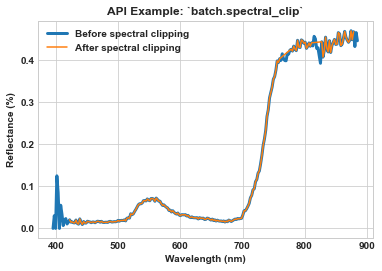

In [27]:
import seaborn as sns

fname = os.path.join(base_dir, 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1011-spatial-crop.bip')
hsbatch.io.read_cube(fname)
spy_mem = hsbatch.io.spyfile.open_memmap()  # datacube before clipping
meta_bands = list(hsbatch.io.tools.meta_bands.values())
fname = os.path.join(base_dir, 'spec_clip', 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1011-spec-clip.bip')
hsbatch.io.read_cube(fname)
spy_mem_clip = hsbatch.io.spyfile.open_memmap()  # datacube after clipping
meta_bands_clip = list(hsbatch.io.tools.meta_bands.values())
ax = sns.lineplot(x=meta_bands, y=spy_mem[26][29], label='Before spectral clipping', linewidth=3)
ax = sns.lineplot(x=meta_bands_clip, y=spy_mem_clip[26][29], label='After spectral clipping', ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `batch.spectral_clip`', weight='bold')

***

## `batch.spectral_mimic`
Batch processing tool to spectrally mimic a multispectral sensor for multiple datacubes in the same way. [[API]](api/hs_process.batch.html#hs_process.batch.spectral_mimic)

**Note:** The following example builds on the results of the [batch.spatial_crop tutorial](tutorial_batch.html#batch.spatial_crop). Please complete the `batch.spatial_crop` tutorial example to be sure your directory (i.e., `base_dir`) is populated with multiple hyperspectral datacubes. The following example will be using datacubes located in the following directory: `F:\\nigo0024\Documents\hs_process_demo\spatial_crop`

Load and initialize the `batch` module, checking to be sure the directory exists.

In [28]:
import os
from hs_process import batch

base_dir = os.path.join(data_dir, 'spatial_crop')
print(os.path.isdir(base_dir))
hsbatch = batch(base_dir, search_ext='.bip', progress_bar=True)  # searches for all files in ``base_dir`` with a ".bip" file extension

True


Use `batch.spectral_mimic` to spectrally mimic the Sentinel-2A multispectral satellite sensor.

In [29]:
hsbatch.spectral_mimic(base_dir=base_dir, folder_name='spec_mimic',
                       name_append='sentinel-2a',
                       sensor='sentinel-2a', center_wl='weighted',
                       out_force=True)

Processing file 39/40: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.36it/s]


Use `seaborn` to visualize the spectra of a single pixel in one of the processed images.

Text(0.5, 1.0, 'API Example: `batch.spectral_mimic`')

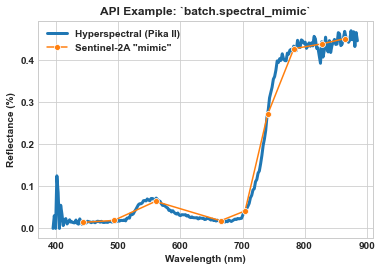

In [30]:
import seaborn as sns
fname = os.path.join(base_dir, 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1011-spatial-crop.bip')
hsbatch.io.read_cube(fname)
spy_mem = hsbatch.io.spyfile.open_memmap()  # datacube before mimicking
meta_bands = list(hsbatch.io.tools.meta_bands.values())
fname = os.path.join(base_dir, 'spec_mimic', 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1011-sentinel-2a.bip')
hsbatch.io.read_cube(fname)
spy_mem_sen2a = hsbatch.io.spyfile.open_memmap()  # datacube after mimicking
meta_bands_sen2a = list(hsbatch.io.tools.meta_bands.values())
ax = sns.lineplot(x=meta_bands, y=spy_mem[26][29], label='Hyperspectral (Pika II)', linewidth=3)
ax = sns.lineplot(x=meta_bands_sen2a, y=spy_mem_sen2a[26][29], label='Sentinel-2A "mimic"', marker='o', ms=6, ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `batch.spectral_mimic`', weight='bold')

Use `spec_mod.spectral_mimic` to mimic the [Sentera 6x spectral configuration](https://sentera.com/6x/) and compare to both hyperspectral and Sentinel-2A.

Processing file 39/40: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.18it/s]


Text(0.5, 1.0, 'API Example: `batch.spectral_mimic`')

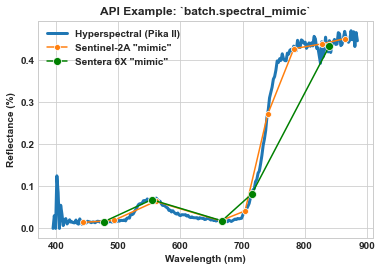

In [31]:
hsbatch.spectral_mimic(base_dir=base_dir, folder_name='spec_mimic',
                       name_append='sentera-6x',
                       sensor='sentera_6x', center_wl='weighted',
                       out_force=True)

fname = os.path.join(base_dir, 'spec_mimic', 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1011-sentera-6x.bip')
hsbatch.io.read_cube(fname)
spy_mem_6x = hsbatch.io.spyfile.open_memmap()  # datacube after mimicking
meta_bands_6x = list(hsbatch.io.tools.meta_bands.values())
ax = sns.lineplot(x=meta_bands, y=spy_mem[26][29], label='Hyperspectral (Pika II)', linewidth=3)
ax = sns.lineplot(x=meta_bands_sen2a, y=spy_mem_sen2a[26][29], label='Sentinel-2A "mimic"', marker='o', ms=6, ax=ax)
ax = sns.lineplot(x=meta_bands_6x, y=spy_mem_6x[26][29], label='Sentera 6X "mimic"', color='green', marker='o', ms=8, ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `batch.spectral_mimic`', weight='bold')

And finally, mimic the [Micasense RedEdge-MX](https://micasense.com/rededge-mx/) and compare to hyperspectral, Sentinel-2A, and Sentera 6X.

Processing file 39/40: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.13it/s]


Text(0.5, 1.0, 'API Example: `batch.spectral_mimic`')

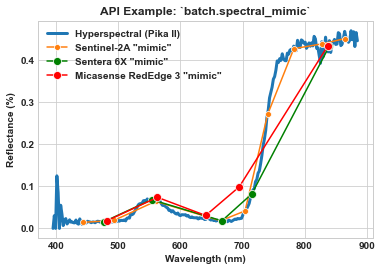

In [32]:
hsbatch.spectral_mimic(base_dir=base_dir, folder_name='spec_mimic',
                       name_append='micasense-rededge-3',
                       sensor='micasense_rededge_3', center_wl='weighted',
                       out_force=True)

fname = os.path.join(base_dir, 'spec_mimic', 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1011-micasense-rededge-3.bip')
hsbatch.io.read_cube(fname)
spy_mem_re3 = hsbatch.io.spyfile.open_memmap()  # datacube after mimicking
meta_bands_re3 = list(hsbatch.io.tools.meta_bands.values())
ax = sns.lineplot(x=meta_bands, y=spy_mem[26][29], label='Hyperspectral (Pika II)', linewidth=3)
ax = sns.lineplot(x=meta_bands_sen2a, y=spy_mem_sen2a[26][29], label='Sentinel-2A "mimic"', marker='o', ms=6, ax=ax)
ax = sns.lineplot(x=meta_bands_6x, y=spy_mem_6x[26][29], label='Sentera 6X "mimic"', color='green', marker='o', ms=8, ax=ax)
ax = sns.lineplot(x=meta_bands_re3, y=spy_mem_re3[26][29], label='Micasense RedEdge 3 "mimic"', color='red', marker='o', ms=8, ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `batch.spectral_mimic`', weight='bold')

***

## `batch.spectral_resample`
Batch processing tool to spectrally resample (a.k.a. "bin") multiple datacubes in the same way. [[API]](api/hs_process.batch.html#hs_process.batch.spectral_resample)

**Note:** The following example builds on the results of the [batch.spatial_crop tutorial](tutorial_batch.html#batch.spatial_crop). Please complete the `batch.spatial_crop` tutorial example to be sure your directory (i.e., `base_dir`) is populated with multiple hyperspectral datacubes. The following example will be using datacubes located in the following directory: `F:\\nigo0024\Documents\hs_process_demo\spatial_crop`

Load and initialize the `batch` module, checking to be sure the directory exists.

In [33]:
import os
from hs_process import batch

base_dir = os.path.join(data_dir, 'spatial_crop')
print(os.path.isdir(base_dir))
hsbatch = batch(base_dir, search_ext='.bip', progress_bar=True)  # searches for all files in ``base_dir`` with a ".bip" file extension

True


Use `batch.spectral_resample` to bin (a.k.a., "group") all spectral bands into 20 nm bandwidth bands (from ~2.3 nm bandwidth originally) on a per-pixel basis.

In [34]:
hsbatch.spectral_resample(base_dir=base_dir, folder_name='spec_bin',
                          name_append='spec-bin-20',
                          bandwidth=20, out_force=True)

Processing file 39/40: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 55.20it/s]


Use `seaborn` to visualize the spectra of a single pixel in one of the processed images.

Text(0.5, 1.0, 'API Example: `batch.spectral_resample`')

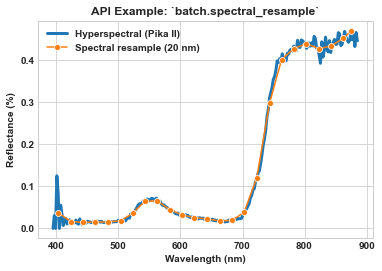

In [35]:
import seaborn as sns
fname = os.path.join(base_dir, 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1011-spatial-crop.bip')
hsbatch.io.read_cube(fname)
spy_mem = hsbatch.io.spyfile.open_memmap()  # datacube before resampling
meta_bands = list(hsbatch.io.tools.meta_bands.values())
fname = os.path.join(base_dir, 'spec_bin', 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1011-spec-bin-20.bip')
hsbatch.io.read_cube(fname)
spy_mem_bin = hsbatch.io.spyfile.open_memmap()  # datacube after resampling
meta_bands_bin = list(hsbatch.io.tools.meta_bands.values())
ax = sns.lineplot(x=meta_bands, y=spy_mem[26][29], label='Hyperspectral (Pika II)', linewidth=3)
ax = sns.lineplot(x=meta_bands_bin, y=spy_mem_bin[26][29], label='Spectral resample (20 nm)', marker='o', ms=6, ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `batch.spectral_resample`', weight='bold')

***

## `batch.spectral_smooth`
Batch processing tool to spectrally smooth multiple datacubes in the same way. [[API]](api/hs_process.batch.html#hs_process.batch.spectral_smooth)

**Note:** The following example builds on the results of the [batch.spatial_crop tutorial](tutorial_batch.html#batch.spatial_crop). Please complete the `batch.spatial_crop` tutorial example to be sure your directory (i.e., `base_dir`) is populated with multiple hyperspectral datacubes. The following example will be using datacubes located in the following directory: `F:\\nigo0024\Documents\hs_process_demo\spatial_crop`

Load and initialize the `batch` module, checking to be sure the directory exists.

In [36]:
import os
from hs_process import batch

base_dir = os.path.join(data_dir, 'spatial_crop')
print(os.path.isdir(base_dir))
hsbatch = batch(base_dir, search_ext='.bip', progress_bar=True)  # searches for all files in ``base_dir`` with a ".bip" file extension

True


Use `batch.spectral_smooth` to perform a *Savitzky-Golay* smoothing operation on each image/pixel in `base_dir`. The `window_size` and `order` can be adjusted to achieve desired smoothing results.

In [37]:
hsbatch.spectral_smooth(base_dir=base_dir, folder_name='spec_smooth',
                        window_size=11, order=2, out_force=True)

Processing file 39/40: 100%|████████████████████████████████████████████████████████████████████| 40/40 [01:00<00:00,  1.52s/it]


Use [Seaborn](https://seaborn.pydata.org/index.html) to visualize the spectra of a single pixel in one of the processed images.

Text(0.5, 1.0, 'API Example: `batch.spectral_smooth`')

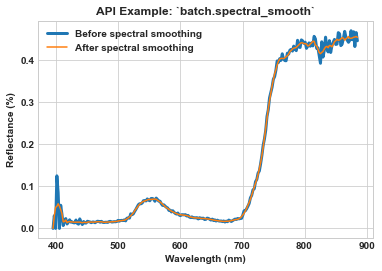

In [38]:
import seaborn as sns

fname = os.path.join(base_dir, 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1011-spatial-crop.bip')
hsbatch.io.read_cube(fname)
spy_mem = hsbatch.io.spyfile.open_memmap()  # datacube before smoothing
meta_bands = list(hsbatch.io.tools.meta_bands.values())
fname = os.path.join(base_dir, 'spec_smooth', 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_1011-spec-smooth.bip')
hsbatch.io.read_cube(fname)
spy_mem_clip = hsbatch.io.spyfile.open_memmap()  # datacube after smoothing
meta_bands_clip = list(hsbatch.io.tools.meta_bands.values())
ax = sns.lineplot(x=meta_bands, y=spy_mem[26][29], label='Before spectral smoothing', linewidth=3)
ax = sns.lineplot(x=meta_bands_clip, y=spy_mem_clip[26][29], label='After spectral smoothing', ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `batch.spectral_smooth`', weight='bold')